<a href="https://colab.research.google.com/github/nahomtse/ThesisGCPNahom/blob/main/Trainandtest_data_maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/


/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan


In [1]:
pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.2 MB/s eta 0:00:00


In [7]:
!pip install gurobipy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.8 MB/s eta 0:00:00


In [3]:
pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pdb
import torch
import matplotlib.pyplot as plt
import numpy as np
import igraph
%matplotlib inline
import pandas as pd
import scipy
from utils import graph_from_scores ###
import networkx as nx
import scipy.io
from scipy.sparse import coo_matrix, isspmatrix

import gurobipy as gp
from gurobipy import *

import tensorflow as tf
import random
######################################################################################
# Create environment with WLS license
e = gp.Env(empty=True)
e.setParam('WLSACCESSID', '5f70bf63-9610-412d-8ca1-551e7e052c61')
e.setParam('WLSSECRET', '190b5abe-a47c-4738-b218-bb7821931920')
e.setParam('LICENSEID', 887511)
#e.setParam('OutputFlag', 0)
e.start()
######################################################################################
varY_list = []
varY2_list = []
lengte = []
werk = 100
ranlist = []
ran = []

# for i in range(werk):
    #Let's say I will have 100 nodes and the connection probability is 0.4
n = 30
# p = 0.2
# piet = np.arange(0,1, (1/werk))
# pietje = piet.tolist()
for p in range(0,werk,1):
    # G = nx.barabasi_albert_graph(n,(random.randint(0, n)))
    #G = nx.barabasi_albert_graph(n,10)
    G= nx.erdos_renyi_graph(n,(p/(werk)))
    #G= nx.erdos_renyi_graph(n,((p+(1*werk))/(werk*5)))
    #G = nx.watts_strogatz_graph(n,10,(p/(werk*10)))
    Gr = nx.to_numpy_array(G)
    
    ranlist.append(Gr)
    ran.append(list(ranlist))
    randy = np.asarray(ran[p])
    xtrain = randy 

    # print(randy.shape)
    G_new = nx.from_numpy_array(randy[p])
    # Create the model within the Gurobi environment

    m = gp.Model('chrom_num', env =e)
    
    # get maximum number of variables necessary
    k = max(dict(nx.degree(G_new)).values()) + 1
    K= range(k)
#################################################################################################################################
    # create k binary variables, y_0 ... y_{k-1} to indicate whether color k is used
    y = []
    for j in range(k):
      y.append(m.addVar(vtype=gp.GRB.BINARY, name='y_%d' % j, obj=1))

    # create n * k binary variables, x_{l,j} that is 1 if node l is colored with j
    x = []
    for l in range(n):
      x.append([])
      for j in range(k):
        x[-1].append(m.addVar(vtype=gp.GRB.BINARY, name='x_%d_%d' % (l, j), obj=0))


    # label_dict = {}
    # label_num = 0
    # for j in range(n):
    #       if (y[j] == 0):
    #           y[j] = 0  # so if value of out put is zero, than varY remains zero
              
    #       else:
    #           if (varY[j]) in label_dict:
    #              varY[j] = label_dict[varY[j]]
    #           else:
    #              label_dict[varY[j]] = label_num #if the value is already in the label_dict, no new label/color has to be made
    #              varY[j] = label_num
    #              label_num = label_num + 1  


    # objective function is minimize colors used --> sum of y_0 ... y_{k-1}
    m.setObjective(gp.quicksum(y[j] for j in K), gp.GRB.MINIMIZE)
    m.update()

    # add constraint -- each node gets exactly one color (sum of colors used is 1)
    for u in range(n):
        m.addConstr(gp.quicksum(x[u]) == 1, name='NC_%d')

    # add constraint -- keep track of colors used (y_j is set high if any time j is used)
    for l in range(n):
        for j in range(k):
            m.addConstr(x[u][j] <= y[j], name='SH_%d_%d')

    # add constraint -- adjacent nodes have different colors
    for u in range(n):
        for v in G[u]:
            if v > u:
                for j in range(k):
                    m.addConstr(x[u][j] + x[v][j] <= 1, name='ADJ_%d_%d_COL_%d')

    # add constraint -- adjacent nodes have different colors
    for u in range(n):
        for v in G[u]:
            if v > u:
                for j in range(k):
                    m.addConstr(x[u][j] + x[v][j] <= y[j], name='ADJ_%d_%d_COL_%d')
#################################################################################################################################
    # update model, solve, return the chromatic number
    
    m.update()
    #m.setParam('MIPGap', 0.05)
    m.setParam('TimeLimit', 15)
    m.optimize()
    #chrom_num = []
    
    chrom_num = m.objVal
    chrom_num_int = int(chrom_num)
    print('-------')
    print('-------')
    print("chromatic number of this graph is ", m.objVal)


    varZ= m.getAttr("x")
    varX = m.getVars()  
    lengte.append(len(y))
    vargurY = varZ[0:lengte[p]]
    vargurX = varZ[lengte[p]:] 

    varY3_reshape = np.reshape(vargurX,(n,lengte[p]))
    varY3_backup = varY3_reshape
    # print('backupVarY3', varY3_backup)
    # with the next loop colors are assigned to each node according to the solver and shaped to size of the graph 
    for ti in range(chrom_num_int):
      varY3_reshape[:,ti] = varY3_reshape[:,ti]*(ti+1)
      varY3_reshape_new = np.extract(varY3_reshape!=0, varY3_reshape)
      varY3_reshape_list = varY3_reshape_new.tolist()
      # varY3_reshape_list = ertg.tolist()
    # print('de gereshapte versie', varY3_reshape)
    # print('alleen de kleuren', varY3_reshape_new)
    # y2_train.shape
    varY_list.append(varY3_reshape_list)
    varY2_list.append(list(varY_list))
    varY3 = np.asarray(varY2_list[p])
    y2_train = tf.keras.utils.to_categorical(y = varY3, num_classes=n+1)

    m.reset()
##########################################################################################################
print('shape van de reshape is',varY3.shape)
print(varY3)
print('n is ', n)
print('loop is ', werk)
print(y2_train.shape)

np.save('testset/xtest_100_erdos.npy', xtrain)
np.save('testset/ytest_100_erdos.npy', y2_train)
xtest_100_erdos = np.load('testset/xtest_100_erdos.npy')
ytest_100_erdos = np.load('testset/ytest_100_erdos.npy')

Set parameter TimeLimit to value 15
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to 482621nt@student.eur.nl
Optimize a model with 2656 rows, 403 columns and 6760 nonzeros
Model fingerprint: 0x290d2b8e
Variable types: 0 continuous, 403 integer (403 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 13.0000000
Presolve removed 1872 rows and 0 columns
Presolve time: 0.08s
Presolved: 784 rows, 403 columns, 2990 nonzeros
Variable types: 0 continuous, 403 integer (403 binary)

Root relaxation: objective 4.000000e+00, 524 iterations, 0.04 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bound

KeyboardInterrupt: ignored

# GAN

**** Using VAL criterion for early stopping with max patience of: 10****
iteration: 1      critic: 5.296368      gen 0.042654
iteration: 11      critic: 0.259577      gen 0.142565
iteration: 21      critic: -0.000025      gen 0.146384
iteration: 31      critic: -0.021059      gen 0.170060
iteration: 41      critic: -0.048914      gen 0.164562
iteration: 51      critic: -0.073845      gen 0.171080
iteration: 61      critic: -0.074547      gen 0.141187
iteration: 71      critic: -0.106495      gen 0.093347
iteration: 81      critic: -0.103930      gen 0.113067
iteration: 91      critic: -0.080608      gen 0.055591


KeyboardInterrupt: ignored

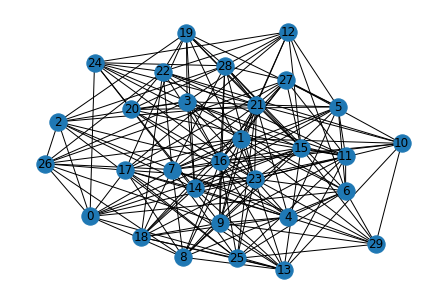

In [9]:

import training 
from training import Trainer 
import utils 
import pdb
import torch
import matplotlib.pyplot as plt
import numpy as np
import igraph
%matplotlib inline
import pandas as pd
import scipy
from utils import graph_from_scores ###
import networkx as nx
import scipy.io
from scipy.sparse import coo_matrix, isspmatrix

import gurobipy as gp
from gurobipy import *

import tensorflow as tf
import random
######################################################################################
###################################################################################################################################################
# create test graph (THIS IS AN EXAMPLE)
n_test = 30
p_test = 0.6
m_test = 27 ###########################################################################################################
q_test = 12
#G_test = nx.erdos_renyi_graph(n_test, p_test)
#G_test = nx.barabasi_albert_graph(n_test,m_test)
# G_test = nx.barabasi_albert_graph(n_test,m_test)
G_test = nx.watts_strogatz_graph(n_test,q_test,p_test)


graph = nx.to_numpy_array(G_test)
#graph = np.pad(graph, (35,35) , mode= 'edge')
graph[graph!=0] = 1.0
graph_nx = nx.from_numpy_array(graph)
graph_sparse = scipy.sparse.csr_matrix(graph)

n_edges = graph.sum()

nx.draw(graph_nx, with_labels = True)
graph_sparse
###################################################################################################################################################
trainer = Trainer(graph_sparse, len(graph), max_iterations=20000, rw_len=6, batch_size=128, H_gen=40, H_disc=30, H_inp=128, z_dim=16, lr=0.0003,
                  n_critic=3, gp_weight=10.0, betas=(.5, .9), l2_penalty_disc=5e-5, l2_penalty_gen=1e-7, temp_start=5.0,  
                  val_share=0.2, test_share=0.1, seed=20, set_ops=False) #max iterationn = 20000

trainer.train(create_graph_every=100, plot_graph_every=200, num_samples_graph=50000, stopping_criterion='val')
###################################################################################################################################################
trans_mat = trainer.create_transition_matrix(50000)
graph_synthetic = []
for i in range(100):
    graph_sampled = graph_from_scores(trans_mat, n_edges)
    graph_synthetic.append(graph_sampled)
    graph_nx_sampled = nx.from_numpy_array(graph_sampled)
    nx.draw(graph_nx_sampled, node_size=25, alpha=0.5)
    plt.show()


for i, graph_sampled in enumerate(graph_synthetic):
    graph_sampled = scipy.sparse.csc_matrix(graph_sampled)
    path = 'graph_eigendata_test(n=30)_basi_30_12'+str(i) + '.npz'
    scipy.sparse.save_npz(path, graph_sampled)
###################################################################################################################################################
graph_sampled = scipy.sparse.csr_matrix.toarray(graph_sampled)
t2 = np.array(graph_synthetic)
print(t2.shape)

fake_graph = np.reshape(graph_sampled, (1,) + (graph_sampled.shape))
x2_pred = fake_graph
test_B = nx.from_numpy_array(graph_sampled)

###################################################################################################################################################
varY_list_test = []
varY2_list_test = []
werk = 5
ranlist = []
ran = []
n = 30 
lengte = []
t2 = reshapert
for p in range(werk):
  test_B = nx.from_numpy_array(t2[p])
  m = gp.Model('chrom_num', env =e)
  
  # get maximum number of variables necessary
  k = max(dict(nx.degree(test_B)).values()) + 1
  K= range(k)
  #################################################################################################################################
  # create k binary variables, y_0 ... y_{k-1} to indicate whether color k is used
  y = []
  for j in range(k):
    y.append(m.addVar(vtype=gp.GRB.BINARY, name='y_%d' % j, obj=1))

  # create n * k binary variables, x_{l,j} that is 1 if node l is colored with j
  x = []
  for l in range(n):
    x.append([])
    for j in range(k):
      x[-1].append(m.addVar(vtype=gp.GRB.BINARY, name='x_%d_%d' % (l, j), obj=0))


  # objective function is minimize colors used --> sum of y_0 ... y_{k-1}
  m.setObjective(gp.quicksum(y[j] for j in K), gp.GRB.MINIMIZE)
  m.update()

  # add constraint -- each node gets exactly one color (sum of colors used is 1)
  for u in range(n):
      m.addConstr(gp.quicksum(x[u]) == 1, name='NC_%d')

  # add constraint -- keep track of colors used (y_j is set high if any time j is used)
  for l in range(n):
      for j in range(k):
          m.addConstr(x[u][j] <= y[j], name='SH_%d_%d')

  # add constraint -- adjacent nodes have different colors
  for u in range(n):
      for v in test_B[u]:
          if v > u:
              for j in range(k):
                  m.addConstr(x[u][j] + x[v][j] <= 1, name='ADJ_%d_%d_COL_%d')

  # add constraint -- adjacent nodes have different colors
  for u in range(n):
      for v in test_B[u]:
          if v > u:
              for j in range(k):
                  m.addConstr(x[u][j] + x[v][j] <= y[j], name='ADJ_%d_%d_COL_%d')
  #################################################################################################################################
  # update model, solve, return the chromatic number

  m.update()
  m.setParam('MIPGap', 0.01)
  m.setParam('TimeLimit', 80)
  m.optimize()
  #chrom_num = []

  chrom_num_test = m.objVal
  chrom_num_int_test = int(chrom_num_test)
  print('-------')
  print('-------')
  print("chromatic number of this graph is ", m.objVal)

###################################################################################################################################################
  varZ_test= m.getAttr("x")
  varX_test = m.getVars()  
  lengte.append(len(y))
  vargurY_test = varZ_test[0:lengte[p]]
  vargurX_test = varZ_test[lengte[p]:] 

  varY3_reshape_test = np.reshape(vargurX_test,(n,lengte[p]))
  varY3_backup_test = varY3_reshape_test
  # print('backupVarY3', varY3_backup)
  for ti in range(chrom_num_int_test):
    varY3_reshape_test[:,ti] = varY3_reshape_test[:,ti]*(ti+1)
    varY3_reshape_new_test = np.extract(varY3_reshape_test !=0, varY3_reshape_test)
    varY3_reshape_list_test = varY3_reshape_new_test.tolist()
  # print('de gereshapte versie', varY3_reshape)
  # print('alleen de kleuren', varY3_reshape_new)
  # y2_train.shape
  varY_list_test.append(varY3_reshape_list_test)
  varY2_list_test.append(list(varY_list_test))
  varY3_test = np.asarray(varY2_list_test[p])
#   y2_train_test = tf.keras.utils.to_categorical(y = varY3_test, num_classes=n+1)

  m.reset()
###################################################################################################################################################  
np.save('testset/xtest_5_faken30.npy', fake_graph)
np.save('testset/ytest_5_faken30.npy', y2_train_test)
x_test =  np.load('testset/xtest_5_faken30.npy')
y_test = np.load('testset/ytest_5_faken30.npy')

# Dataset 6 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import scipy as sp
import random
import networkx as nx
import os.path as osp

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch_geometric
import torch_geometric.utils
from torch_geometric.utils import (to_networkx)
from torch_geometric.datasets import KarateClub, Planetoid, TUDataset, GNNBenchmarkDataset, QM7b, QM9, MD17, ZINC, BA2MotifDataset, AQSOL, MoleculeNet,GEDDataset  
from torch_geometric.data import DataLoader
from torch_geometric.nn.inits import uniform
from torch.nn import Parameter as Param
from torch import Tensor 

###################################################################################################################################################
#note that these dataset names are done synchronically
dataset = 'MUTAG'
path = osp.join('data', dataset)
dataset = TUDataset(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]


dataset = 'ENZYMES'
path = osp.join('data', dataset)
dataset = TUDataset(path, dataset, transform=T.NormalizeFeatures())
# data = dataset[0]

dataset = 'k'
path = osp.join('data', dataset)
dataset = KarateClub(transform=T.NormalizeFeatures())
# data = dataset[0]

dataset = 'CSL'
path = osp.join('data', dataset)
dataset = GNNBenchmarkDataset(path, dataset, transform=T.NormalizeFeatures())
# data = dataset[0]

dataset = 'CSL'
path = osp.join('data', dataset)
dataset = QM7b(path, transform=T.NormalizeFeatures())
# data = dataset[0]

dataset = 'QM9'
path = osp.join('data', dataset)
dataset = QM9(path, transform=T.NormalizeFeatures())
# data = dataset[0]

dataset = 'BA2MotifDataset'
path = osp.join('data', dataset)
dataset = BA2MotifDataset(path, transform=T.NormalizeFeatures())
# data = dataset[0]

dataset = 'AIDS700nef'
path = osp.join('data', dataset)
dataset = GEDDataset(path, dataset,  transform=T.NormalizeFeatures())
# data = dataset[0]


dataset = 'LINUX'
path = osp.join('data', dataset)
dataset = GEDDataset(path, dataset,  transform=T.NormalizeFeatures())
# data = dataset[0]

dataset = 'ALKANE'
path = osp.join('data', dataset)
dataset = GEDDataset(path, dataset,  transform=T.NormalizeFeatures())
# data = dataset[0]


###################################################################################################################################################
Gm3 =nx.Graph() 
Gm3.add_edge(1,2)
Gm3.add_edge(1,4)
Gm3.add_edge(1,7)
Gm3.add_edge(1,9)
Gm3.add_edge(2,3)
Gm3.add_edge(2,6)
Gm3.add_edge(2,8)
Gm3.add_edge(3,5)
Gm3.add_edge(3,7)
Gm3.add_edge(3,10)
Gm3.add_edge(4,5)
Gm3.add_edge(4,6)
Gm3.add_edge(4,10)
Gm3.add_edge(5,8)
Gm3.add_edge(5,9)
Gm3.add_edge(6,11)
Gm3.add_edge(7,11)
Gm3.add_edge(8,11)
Gm3.add_edge(9,11)
Gm3.add_edge(10,11)
nx.draw(Gm3,with_labels = True)

###################################################################################################################################################
Gm4 =nx.Graph() 
Gm4.add_edge(1,2)
Gm4.add_edge(1,4)
Gm4.add_edge(1,7)
Gm4.add_edge(1,9)
Gm4.add_edge(1,13)
Gm4.add_edge(1,15)
Gm4.add_edge(1,18)
Gm4.add_edge(1,20)
Gm4.add_edge(2,3)
Gm4.add_edge(2,6)
Gm4.add_edge(2,8)
Gm4.add_edge(2,12)
Gm4.add_edge(2,14)
Gm4.add_edge(2,17)
Gm4.add_edge(2,19)
Gm4.add_edge(3,5)
Gm4.add_edge(3,7)
Gm4.add_edge(3,10)
Gm4.add_edge(3,13)
Gm4.add_edge(3,16)
Gm4.add_edge(3,18)
Gm4.add_edge(3,21)
Gm4.add_edge(4,5)
Gm4.add_edge(4,6)
Gm4.add_edge(4,10)
Gm4.add_edge(4,12)
Gm4.add_edge(4,16)
Gm4.add_edge(4,17)
Gm4.add_edge(4,21)
Gm4.add_edge(5,8)
Gm4.add_edge(5,9)
Gm4.add_edge(5,14)
Gm4.add_edge(5,15)
Gm4.add_edge(5,19)
Gm4.add_edge(5,20)
Gm4.add_edge(6,11)
Gm4.add_edge(6,13)
Gm4.add_edge(6,15)
Gm4.add_edge(6,22)
Gm4.add_edge(7,11)
Gm4.add_edge(7,12)
Gm4.add_edge(7,14)
Gm4.add_edge(7,22)
Gm4.add_edge(8,11)
Gm4.add_edge(8,13)
Gm4.add_edge(8,16)
Gm4.add_edge(8,22)
Gm4.add_edge(9,11)
Gm4.add_edge(9,12)
Gm4.add_edge(9,16)
Gm4.add_edge(9,22)
Gm4.add_edge(10,11)
Gm4.add_edge(10,14)
Gm4.add_edge(10,15)
Gm4.add_edge(10,22)
Gm4.add_edge(11,17)
Gm4.add_edge(11,18)
Gm4.add_edge(11,19)
Gm4.add_edge(11,20)
Gm4.add_edge(11,21)
Gm4.add_edge(12,23)
Gm4.add_edge(13,23)
Gm4.add_edge(14,23)
Gm4.add_edge(15,23)
Gm4.add_edge(16,23)
Gm4.add_edge(17,23)
Gm4.add_edge(18,23)
Gm4.add_edge(19,23)
Gm4.add_edge(20,23)
Gm4.add_edge(21,23)
Gm4.add_edge(22,23)
nx.draw(Gm4,with_labels = True)
###################################################################################################################################################
G5 = nx.Graph() 
G5.add_edge(1,7)
G5.add_edge(1,13)
G5.add_edge(1,19)
G5.add_edge(1,25)
G5.add_edge(1,2)
G5.add_edge(1,3)
G5.add_edge(1,4)
G5.add_edge(1,5)
G5.add_edge(1,6)
G5.add_edge(1,11)
G5.add_edge(1,16)
G5.add_edge(1,21)
G5.add_edge(2,8)
G5.add_edge(2,14)
G5.add_edge(2,20)
G5.add_edge(2,6)
G5.add_edge(2,3)
G5.add_edge(2,4)
G5.add_edge(2,5)
G5.add_edge(2,7)
G5.add_edge(2,12)
G5.add_edge(2,17)
G5.add_edge(2,22)
G5.add_edge(2,1)
G5.add_edge(3,9)
G5.add_edge(3,15)
G5.add_edge(3,7)
G5.add_edge(3,11)
G5.add_edge(3,4)
G5.add_edge(3,5)
G5.add_edge(3,8)
G5.add_edge(3,13)
G5.add_edge(3,18)
G5.add_edge(3,23)
G5.add_edge(3,2)
G5.add_edge(3,1)
G5.add_edge(4,10)
G5.add_edge(4,8)
G5.add_edge(4,12)
G5.add_edge(4,16)
G5.add_edge(4,5)
G5.add_edge(4,9)
G5.add_edge(4,14)
G5.add_edge(4,19)
G5.add_edge(4,24)
G5.add_edge(4,3)
G5.add_edge(4,2)
G5.add_edge(4,1)
G5.add_edge(5,9)
G5.add_edge(5,13)
G5.add_edge(5,17)
G5.add_edge(5,21)
G5.add_edge(5,10)
G5.add_edge(5,15)
G5.add_edge(5,20)
G5.add_edge(5,25)
G5.add_edge(5,4)
G5.add_edge(5,3)
G5.add_edge(5,2)
G5.add_edge(5,1)
G5.add_edge(6,12)
G5.add_edge(6,18)
G5.add_edge(6,24)
G5.add_edge(6,7)
G5.add_edge(6,8)
G5.add_edge(6,9)
G5.add_edge(6,10)
G5.add_edge(6,11)
G5.add_edge(6,16)
G5.add_edge(6,21)
G5.add_edge(6,2)
G5.add_edge(6,1)
G5.add_edge(7,13)
G5.add_edge(7,19)
G5.add_edge(7,25)
G5.add_edge(7,11)
G5.add_edge(7,8)
G5.add_edge(7,9)
G5.add_edge(7,10)
G5.add_edge(7,12)
G5.add_edge(7,17)
G5.add_edge(7,22)
G5.add_edge(7,6)
G5.add_edge(7,3)
G5.add_edge(7,2)
G5.add_edge(7,1)
G5.add_edge(8,14)
G5.add_edge(8,20)
G5.add_edge(8,12)
G5.add_edge(8,16)
G5.add_edge(8,9)
G5.add_edge(8,10)
G5.add_edge(8,13)
G5.add_edge(8,18)
G5.add_edge(8,23)
G5.add_edge(8,7)
G5.add_edge(8,6)
G5.add_edge(8,4)
G5.add_edge(8,3)
G5.add_edge(8,2)
G5.add_edge(9,15)
G5.add_edge(9,13)
G5.add_edge(9,17)
G5.add_edge(9,21)
G5.add_edge(9,10)
G5.add_edge(9,14)
G5.add_edge(9,19)
G5.add_edge(9,24)
G5.add_edge(9,8)
G5.add_edge(9,7)
G5.add_edge(9,6)
G5.add_edge(9,5)
G5.add_edge(9,4)
G5.add_edge(9,3)
G5.add_edge(10,14)
G5.add_edge(10,18)
G5.add_edge(10,22)
G5.add_edge(10,15)
G5.add_edge(10,20)
G5.add_edge(10,25)
G5.add_edge(10,9)
G5.add_edge(10,8)
G5.add_edge(10,7)
G5.add_edge(10,6)
G5.add_edge(10,5)
G5.add_edge(10,4)
G5.add_edge(11,17)
G5.add_edge(11,23)
G5.add_edge(11,12)
G5.add_edge(11,13)
G5.add_edge(11,14)
G5.add_edge(11,15)
G5.add_edge(11,16)
G5.add_edge(11,21)
G5.add_edge(11,7)
G5.add_edge(11,6)
G5.add_edge(11,3)
G5.add_edge(11,1)
G5.add_edge(12,18)
G5.add_edge(12,24)
G5.add_edge(12,16)
G5.add_edge(12,13)
G5.add_edge(12,14)
G5.add_edge(12,15)
G5.add_edge(12,17)
G5.add_edge(12,22)
G5.add_edge(12,11)
G5.add_edge(12,8)
G5.add_edge(12,7)
G5.add_edge(12,6)
G5.add_edge(12,4)
G5.add_edge(12,2)
G5.add_edge(13,19)
G5.add_edge(13,25)
G5.add_edge(13,17)
G5.add_edge(13,21)
G5.add_edge(13,14)
G5.add_edge(13,15)
G5.add_edge(13,18)
G5.add_edge(13,23)
G5.add_edge(13,12)
G5.add_edge(13,11)
G5.add_edge(13,9)
G5.add_edge(13,8)
G5.add_edge(13,7)
G5.add_edge(13,5)
G5.add_edge(13,3)
G5.add_edge(13,1)
G5.add_edge(14,20)
G5.add_edge(14,18)
G5.add_edge(14,22)
G5.add_edge(14,15)
G5.add_edge(14,19)
G5.add_edge(14,24)
G5.add_edge(14,13)
G5.add_edge(14,12)
G5.add_edge(14,11)
G5.add_edge(14,10)
G5.add_edge(14,9)
G5.add_edge(14,8)
G5.add_edge(14,4)
G5.add_edge(14,2)
G5.add_edge(15,19)
G5.add_edge(15,23)
G5.add_edge(15,20)
G5.add_edge(15,25)
G5.add_edge(15,14)
G5.add_edge(15,13)
G5.add_edge(15,12)
G5.add_edge(15,11)
G5.add_edge(15,10)
G5.add_edge(15,9)
G5.add_edge(15,5)
G5.add_edge(15,3)
G5.add_edge(16,22)
G5.add_edge(16,17)
G5.add_edge(16,18)
G5.add_edge(16,19)
G5.add_edge(16,20)
G5.add_edge(16,21)
G5.add_edge(16,12)
G5.add_edge(16,11)
G5.add_edge(16,8)
G5.add_edge(16,6)
G5.add_edge(16,4)
G5.add_edge(16,1)
G5.add_edge(17,23)
G5.add_edge(17,21)
G5.add_edge(17,18)
G5.add_edge(17,19)
G5.add_edge(17,20)
G5.add_edge(17,22)
G5.add_edge(17,16)
G5.add_edge(17,13)
G5.add_edge(17,12)
G5.add_edge(17,11)
G5.add_edge(17,9)
G5.add_edge(17,7)
G5.add_edge(17,5)
G5.add_edge(17,2)
G5.add_edge(18,24)
G5.add_edge(18,22)
G5.add_edge(18,19)
G5.add_edge(18,20)
G5.add_edge(18,23)
G5.add_edge(18,17)
G5.add_edge(18,16)
G5.add_edge(18,14)
G5.add_edge(18,13)
G5.add_edge(18,12)
G5.add_edge(18,10)
G5.add_edge(18,8)
G5.add_edge(18,6)
G5.add_edge(18,3)
G5.add_edge(19,25)
G5.add_edge(19,23)
G5.add_edge(19,20)
G5.add_edge(19,24)
G5.add_edge(19,18)
G5.add_edge(19,17)
G5.add_edge(19,16)
G5.add_edge(19,15)
G5.add_edge(19,14)
G5.add_edge(19,13)
G5.add_edge(19,9)
G5.add_edge(19,7)
G5.add_edge(19,4)
G5.add_edge(19,1)
G5.add_edge(20,24)
G5.add_edge(20,25)
G5.add_edge(20,19)
G5.add_edge(20,18)
G5.add_edge(20,17)
G5.add_edge(20,16)
G5.add_edge(20,15)
G5.add_edge(20,14)
G5.add_edge(20,10)
G5.add_edge(20,8)
G5.add_edge(20,5)
G5.add_edge(20,2)
G5.add_edge(21,22)
G5.add_edge(21,23)
G5.add_edge(21,24)
G5.add_edge(21,25)
G5.add_edge(21,17)
G5.add_edge(21,16)
G5.add_edge(21,13)
G5.add_edge(21,11)
G5.add_edge(21,9)
G5.add_edge(21,6)
G5.add_edge(21,5)
G5.add_edge(21,1)
G5.add_edge(22,23)
G5.add_edge(22,24)
G5.add_edge(22,25)
G5.add_edge(22,21)
G5.add_edge(22,18)
G5.add_edge(22,17)
G5.add_edge(22,16)
G5.add_edge(22,14)
G5.add_edge(22,12)
G5.add_edge(22,10)
G5.add_edge(22,7)
G5.add_edge(22,2)
G5.add_edge(23,24)
G5.add_edge(23,25)
G5.add_edge(23,22)
G5.add_edge(23,21)
G5.add_edge(23,19)
G5.add_edge(23,18)
G5.add_edge(23,17)
G5.add_edge(23,15)
G5.add_edge(23,13)
G5.add_edge(23,11)
G5.add_edge(23,8)
G5.add_edge(23,3)
G5.add_edge(24,25)
G5.add_edge(24,23)
G5.add_edge(24,22)
G5.add_edge(24,21)
G5.add_edge(24,20)
G5.add_edge(24,19)
G5.add_edge(24,18)
G5.add_edge(24,14)
G5.add_edge(24,12)
G5.add_edge(24,9)
G5.add_edge(24,6)
G5.add_edge(24,4)
G5.add_edge(25,24)
G5.add_edge(25,23)
G5.add_edge(25,22)
G5.add_edge(25,21)
G5.add_edge(25,20)
G5.add_edge(25,19)
G5.add_edge(25,15)
G5.add_edge(25,13)
G5.add_edge(25,10)
G5.add_edge(25,7)
G5.add_edge(25,5)
G5.add_edge(25,1)
###################################################################################################################################################
# Gm4 # myciel 4 
# G5 # queen5
# Gm3 # myciel 3

data_E2 =[]
data_Gm3 = nx.to_numpy_array(Gm3)
data_Gm4= nx.to_numpy_array(Gm4)
data_G5= nx.to_numpy_array(G5)
data_E2.append(data_Gm3)    
data_E2.append(data_Gm4)    
data_E2.append(data_G5) 

ran = []
randy = []
randy2 = []
randy3 = []
  
for p in range(len(data_E2)):
    # G_new = data_E[p] 
    tr =30
    
    # ranlist.append(Gr)
    ran.append(list(data_E2))
    randy = np.asarray(ran[p], dtype = object)
    randy2 = np.pad(randy[p], (0, tr - len(randy[p])%tr), 'constant')
    randy3.append(list(randy2))
    xtrain = np.asarray(randy3) 

###################################################################################################################################################
varY_list = []
varY2_list = []
lengte = []
werk = 100
ranlist = []
ran = []
randy2 = []
randy3 = []


data_D2 = []
data_E2 = []
data_B2 =[]
data_C2 = []

# for i in range(werk):
for p in range(len(dataset)):
    data_B = dataset[p].num_nodes #check the nodes
    # data_C = dataset[p].edge_index.shape #check the number of edges
    data_B2.append(data_B)
    #  data_C2.append(data_C)
    # print('number of nodes:', data_B2)
    n = data_B2[p]
    # print('number of edges:', data_C2)
    data_D = torch_geometric.utils.to_scipy_sparse_matrix(edge_index = dataset[p].edge_index, num_nodes = dataset[p].num_nodes)
    data_E= nx.from_scipy_sparse_array(data_D)
    data_D2.append(data_D)
    data_E2.append(data_E)
    G_new = data_E 
    # nx.draw(data_E, with_labels = True)
    # plt.show()
    tr =30
    Gr = nx.to_numpy_array(G_new)
    
    ranlist.append(Gr)
    ran.append(list(ranlist))
    randy = np.asarray(ran[p], dtype = object)
    randy2 = np.pad(randy[p], (0, tr - len(randy[p])%tr), 'constant')
    randy3.append(list(randy2))
    xtrain = np.asarray(randy3) 

    # # print(randy.shape)
    # G_new = nx.from_numpy_array(randy[p])
    m = gp.Model('chrom_num', env =e)
    
    # get maximum number of variables necessary
    k = max(dict(nx.degree(G_new)).values()) + 1
    K= range(k)
#################################################################################################################################
    # create k binary variables, y_0 ... y_{k-1} to indicate whether color k is used
    y = []
    for j in range(k):
      y.append(m.addVar(vtype=gp.GRB.BINARY, name='y_%d' % j, obj=1))

    # create n * k binary variables, x_{l,j} that is 1 if node l is colored with j
    x = []
    for l in range(n):
      x.append([])
      for j in range(k):
        x[-1].append(m.addVar(vtype=gp.GRB.BINARY, name='x_%d_%d' % (l, j), obj=0))


    # label_dict = {}
    # label_num = 0
    # for j in range(n):
    #       if (y[j] == 0):
    #           y[j] = 0  # so if value of out put is zero, than varY remains zero
              
    #       else:
    #           if (varY[j]) in label_dict:
    #              varY[j] = label_dict[varY[j]]
    #           else:
    #              label_dict[varY[j]] = label_num #if the value is already in the label_dict, no new label/color has to be made
    #              varY[j] = label_num
    #              label_num = label_num + 1  


    # objective function is minimize colors used --> sum of y_0 ... y_{k-1}
    m.setObjective(gp.quicksum(y[j] for j in K), gp.GRB.MINIMIZE)
    m.update()

    # add constraint -- each node gets exactly one color (sum of colors used is 1)
    for u in range(n):
        m.addConstr(gp.quicksum(x[u]) == 1, name='NC_%d')

    # add constraint -- keep track of colors used (y_j is set high if any time j is used)
    for l in range(n):
        for j in range(k):
            m.addConstr(x[u][j] <= y[j], name='SH_%d_%d')

    # add constraint -- adjacent nodes have different colors
    for u in range(n):
        for v in G_new[u]:
            if v > u:
                for j in range(k):
                    m.addConstr(x[u][j] + x[v][j] <= 1, name='ADJ_%d_%d_COL_%d')

    # add constraint -- adjacent nodes have different colors
    for u in range(n):
        for v in G_new[u]:
            if v > u:
                for j in range(k):
                    m.addConstr(x[u][j] + x[v][j] <= y[j], name='ADJ_%d_%d_COL_%d')
#################################################################################################################################
    # update model, solve, return the chromatic number
    
    m.update()
    #m.setParam('MIPGap', 0.15)
    m.setParam('TimeLimit', 5)
    m.optimize()
    #chrom_num = []
    
    chrom_num = m.objVal
    chrom_num_int = int(chrom_num)
    print('-------')
    print('-------')
    print("chromatic number of this graph is ", m.objVal)


    varZ= m.getAttr("x")
    varX = m.getVars()  
    lengte.append(len(y))
    vargurY = varZ[0:lengte[p]]
    vargurX = varZ[lengte[p]:] 

    varY3_reshape = np.reshape(vargurX,(n,lengte[p]))
    varY3_backup = varY3_reshape
    # print('backupVarY3', varY3_backup)
    for ti in range(chrom_num_int):
      varY3_reshape[:,ti] = varY3_reshape[:,ti]*(ti+1)
      varY3_reshape_new = np.extract(varY3_reshape!=0, varY3_reshape)
      ertg = np.pad(varY3_reshape_new, (0, tr - len(varY3_reshape_new)%tr), 'constant')  #toegevoegde functie en dan ook nu regel ertg beneden toegegevoed 
      # varY3_reshape_list = varY3_reshape_new.tolist()
      varY3_reshape_list = ertg.tolist()
    # print('de gereshapte versie', varY3_reshape)
    # print('alleen de kleuren', varY3_reshape_new)
    # y2_train.shape
    varY_list.append(varY3_reshape_list)
    varY2_list.append(list(varY_list))
    varY3 = np.asarray(varY2_list[p])
    y2_train = tf.keras.utils.to_categorical(y = varY3, num_classes=tr+1)

    m.reset()

print('shape van de reshape is',varY3.shape)
print(varY3)
print('n is ', n)
print('loop is ', werk)
print(y2_train.shape)
print(xtrain.shape)

###################################################################################################################################################
###################################################################################################################################################
# np.save('exp5/xtest_Mutag_30.npy', xtrain)
# np.save('exp5/ytest_Mutag_30.npy', y2_train)
xtest_Mutag_30 = np.load('exp5/xtest_Mutag_30.npy', allow_pickle= True)
ytest_Mutag_30 = np.load('exp5/ytest_Mutag_30.npy')

np.save('exp5/xtest_Enzymes_130.npy', xtrain)
np.save('exp5/ytest_Enzymes_130.npy', y2_train)
xtest_Enzymes_130 = np.load('exp5/xtest_Enzymes_130.npy', allow_pickle= True)
ytest_Enzymes_130 = np.load('exp5/ytest_Enzymes_130.npy')

np.save('exp5/xtest_Karateclub_40.npy', xtrain)
np.save('exp5/ytest_Karateclub_40.npy', y2_train)
xtest_Karateclub_40 = np.load('exp5/xtest_Karateclub_40.npy', allow_pickle= True)
ytest_Karateclub_40 = np.load('exp5/ytest_Karateclub_40.npy')

np.save('exp5/xtest_CSL_50.npy', xtrain)
np.save('exp5/ytest_CSL_50.npy', y2_train)
xtest_CSL_50 = np.load('exp5/xtest_CSL_50.npy', allow_pickle= True)
ytest_CSL_50 = np.load('exp5/ytest_CSL_50.npy')

np.save('exp5/xtest_QM7b_30.npy', xtrain)
np.save('exp5/ytest_QM7b_30.npy', y2_train)
xtest_QM7b_30 = np.load('exp5/xtest_QM7b_30.npy', allow_pickle= True)
ytest_QM7b_30 = np.load('exp5/ytest_QM7b_30.npy')

np.save('exp5/xtest_QM9_30.npy', xtrain)
np.save('exp5/ytest_QM9_30.npy', y2_train)
xtest_QM9_30 = np.load('exp5/xtest_QM9_30.npy', allow_pickle= True)
ytest_QM9_30 = np.load('exp5/ytest_QM9_30.npy')

np.save('exp5/xtest_MD17_30.npy', xtrain)
np.save('exp5/ytest_MD17_30.npy', y2_train)
xtest_MD17_30 = np.load('exp5/xtest_MD17_30.npy', allow_pickle= True)
ytest_MD17_30 = np.load('exp5/ytest_MD17_30.npy')

np.save('exp5/xtest_MD17_30.npy', xtrain)
np.save('exp5/ytest_MD17_30.npy', y2_train)
xtest_MD17_30 = np.load('exp5/xtest_MD17_30.npy', allow_pickle= True)
ytest_MD17_30 = np.load('exp5/ytest_MD17_30.npy')

np.save('exp5/xtest_Aids_30.npy', xtrain)
np.save('exp5/ytest_Aids_30.npy', y2_train)
xtest_MD17_30 = np.load('exp5/xtest_Aids_30.npy', allow_pickle= True)
ytest_MD17_30 = np.load('exp5/ytest_Aids_30.npy')

np.save('exp5/xtest_Linux_30.npy', xtrain)
np.save('exp5/ytest_Linux_30.npy', y2_train)
xtest_MD17_30 = np.load('exp5/xtest_Linux_30.npy', allow_pickle= True)
ytest_MD17_30 = np.load('exp5/ytest_Linux_30.npy')

np.save('exp5/xtest_Alkane_30.npy', xtrain)
np.save('exp5/ytest_Alkane_30.npy', y2_train)
xtest_MD17_30 = np.load('exp5/xtest_Alkane_30.npy', allow_pickle= True)
ytest_MD17_30 = np.load('exp5/ytest_Alkane_30.npy')
###################################################################################################################################################

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 167, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py", line 361, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/wheel_builder.py", line 348, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/wheel_builder.py", line 222, in _build_one
    wheel_path = _build_one_inside_env(
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/wheel_builder.py", line 269, in _build_one_inside_env
    w